# Importar Bibliotecas Necessárias
Importe as bibliotecas necessárias, incluindo TensorFlow, os, matplotlib e sklearn.

In [ ]:
! pip install tensorflow scikit-learn matplotlib pandas

In [1]:
# Importar Bibliotecas Necessárias
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

2024-11-20 18:57:17.407800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 18:57:17.412745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 18:57:17.428877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732139837.456330  340895 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732139837.464255  340895 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 18:57:17.492242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Carregar e Preparar os Dados
Carregue os dados de treinamento e validação usando image_dataset_from_directory e aplique aumentos de dados.

In [ ]:
# Carregar e Preparar os Dados

# Diretórios dos dados de treinamento e validação
TRAIN_DIR = 'fusion2/'
VALID_DIR = 'fusionValidate2/'

# Carregar as imagens de forma eficiente com image_dataset_from_directory
batch_size = 14
img_height, img_width = 230, 230

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VALID_DIR,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Aplicar aumentos de dados para o conjunto de treino
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

Found 2711 files belonging to 5 classes.
Found 385 files belonging to 5 classes.


W0000 00:00:1732139842.604385  340895 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Definir e Compilar o Modelo
Defina o modelo usando a API Sequential do Keras, adicione camadas e compile o modelo.

In [3]:
# Definir e Compilar o Modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(img_height, img_width, 3)),  # Definindo a forma de entrada
    data_augmentation,  # Aumentos aplicados na entrada
    tf.keras.layers.Rescaling(1./255),  # Normalização das imagens
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),  # Adicionando a camada Flatten
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax')  # Ajuste para o número de classes
])

# Compilar o modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Treinar o Modelo
Treine o modelo usando o método fit e salve o histórico do treinamento.

In [4]:
# Treinar o Modelo

# Callbacks
early_stopping_cb = EarlyStopping(patience=7)
checkpoint_cb = ModelCheckpoint("checkpoint_best_new.keras", save_best_only=True, monitor='val_accuracy')

# Calcular steps_per_epoch e validation_steps
train_image_count = sum([len(files) for _, _, files in os.walk(TRAIN_DIR)])
val_image_count = sum([len(files) for _, _, files in os.walk(VALID_DIR)])
steps_per_epoch = train_image_count // batch_size
validation_steps = val_image_count // batch_size

# Repetir o dataset para evitar o erro de fim de sequência
train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

# Treinar o modelo
history = model.fit(
    train_ds,
    epochs=batch_size,
    steps_per_epoch=steps_per_epoch,  # Ajuste aqui se necessário
    validation_data=val_ds,
    validation_steps=validation_steps,  # Ajuste aqui se necessário
    callbacks=[early_stopping_cb, checkpoint_cb],
    verbose=1
)



Epoch 1/14
193/193 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.3730 - loss: 3.3364 - val_accuracy: 0.3175 - val_loss: 1.3981
Epoch 2/14
193/193 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.4862 - loss: 1.0838 - val_accuracy: 0.3504 - val_loss: 1.3620
Epoch 3/14
193/193 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.5468 - loss: 1.0100 - val_accuracy: 0.4555 - val_loss: 1.1994
Epoch 4/14
193/193 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.6094 - loss: 0.8926 - val_accuracy: 0.5633 - val_loss: 1.0836
Epoch 5/14
193/193 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.6591 - loss: 0.8461 - val_accuracy: 0.4582 - val_loss: 1.2804
Epoch 6/14
193/193 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.6581 - loss: 0.7927 - val_accuracy: 0.5364 - val_loss: 1.0537
Epoch 7/14
193/193 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.7226 - loss: 0.7173 - val_accuracy: 0.5526 - val_loss: 1.1090
Epoch 8/14
193/193 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.7341 - loss: 0.6809 - val_accu

# Plotar Resultados
Plote os resultados de acurácia e perda do treinamento e validação usando matplotlib.

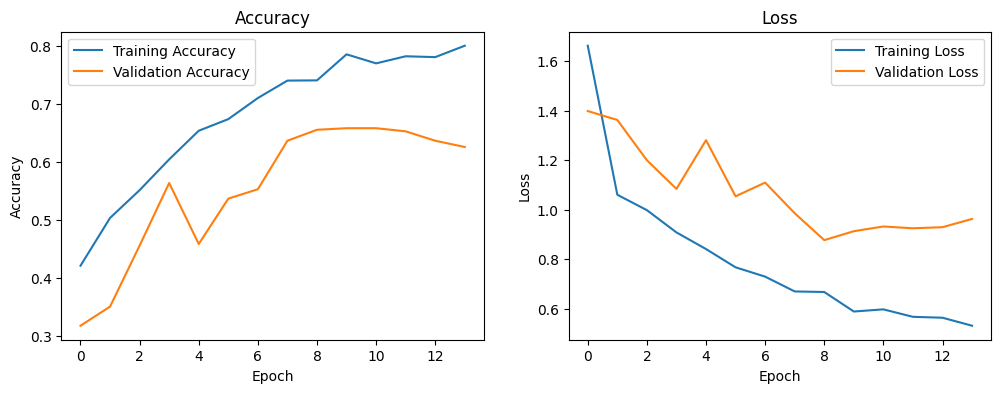

In [5]:
# Plotar os resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plot.png')
plt.show()

385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━

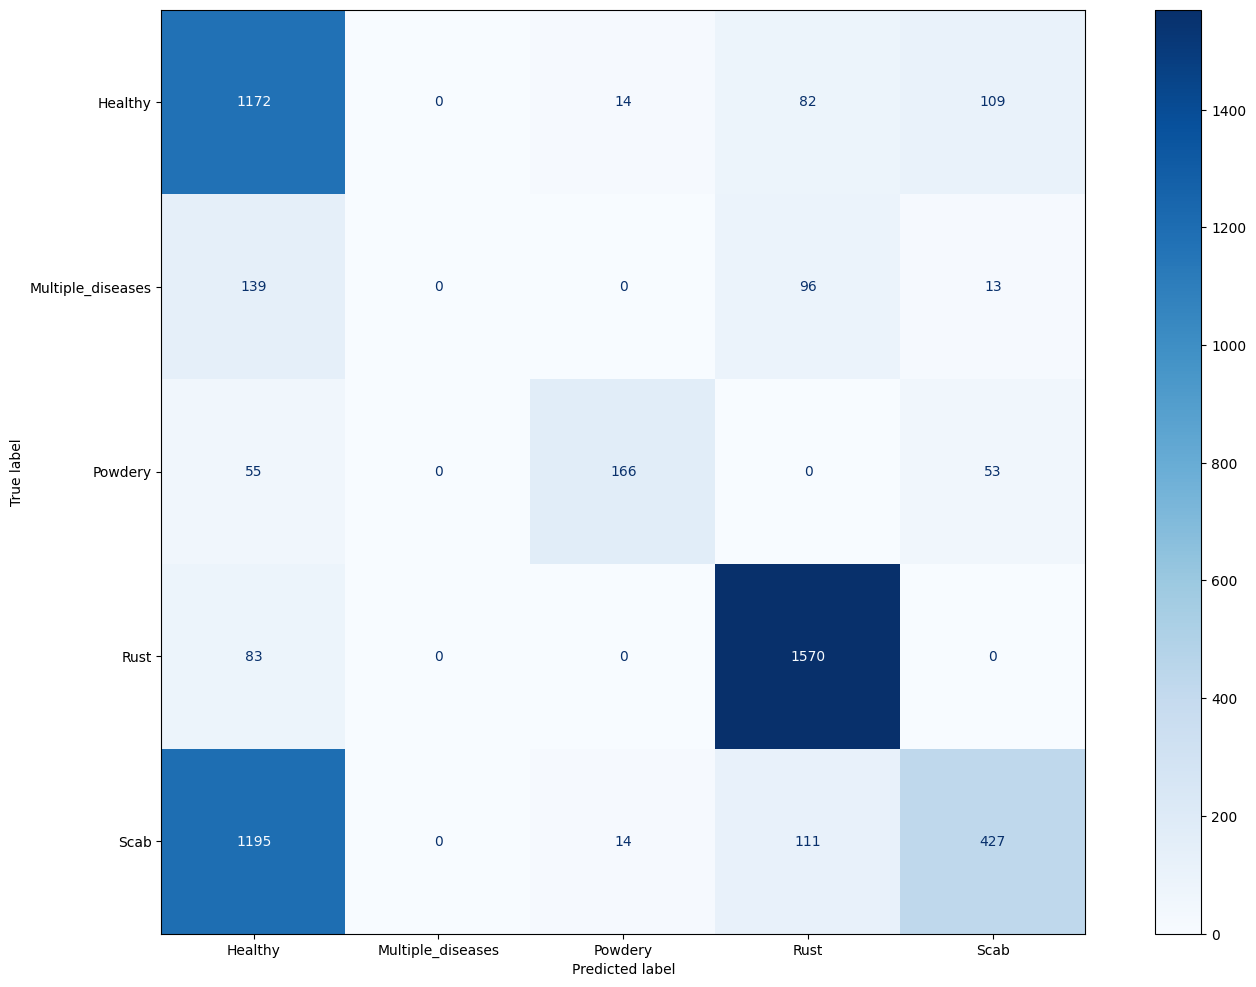

In [29]:
print(val_image_count)

# Matriz de Confusão
y_true = []
y_pred = []

# obter os rótulos
class_names = sorted(os.listdir(TRAIN_DIR))


for images, labels in val_ds.take(val_image_count):
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Construir e plotar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.gcf().set_size_inches(18, 12)  # Ajustar o tamanho da figura
plt.show()

# Quantidade de imagens para cada categoria
plotando as quantidades de imagens disponíveis para cada categoria em treinamento e em validação

In [30]:
# Definir Diretórios de Treinamento e Validação

# Definindo os caminhos para os diretórios de treinamento e validação
train_dir = TRAIN_DIR
validation_dir = VALID_DIR

# Função para contar a quantidade de imagens em cada categoria
def contar_imagens_por_categoria(diretorio):
    categorias = os.listdir(diretorio)
    contagem = {categoria: len(os.listdir(os.path.join(diretorio, categoria))) for categoria in categorias}
    return contagem

# Contando as imagens nos diretórios de treinamento e validação
contagem_treinamento = contar_imagens_por_categoria(train_dir)
contagem_validacao = contar_imagens_por_categoria(validation_dir)

# Exibindo as contagens
print("Contagem de imagens no diretório de treinamento:", contagem_treinamento)
print("Contagem de imagens no diretório de validação:", contagem_validacao)

Contagem de imagens no diretório de treinamento: {'Healthy': 1043, 'Rust': 552, 'Powdery': 80, 'Multiple_diseases': 73, 'Scab': 963}
Contagem de imagens no diretório de validação: {'Healthy': 100, 'Rust': 120, 'Powdery': 20, 'Multiple_diseases': 18, 'Scab': 127}


# Plotando a quantidade de imagens para cada categoria

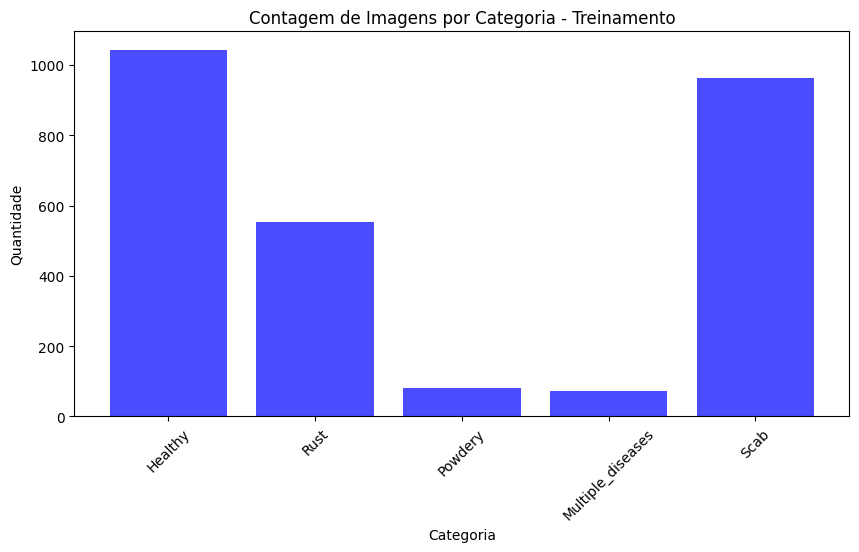

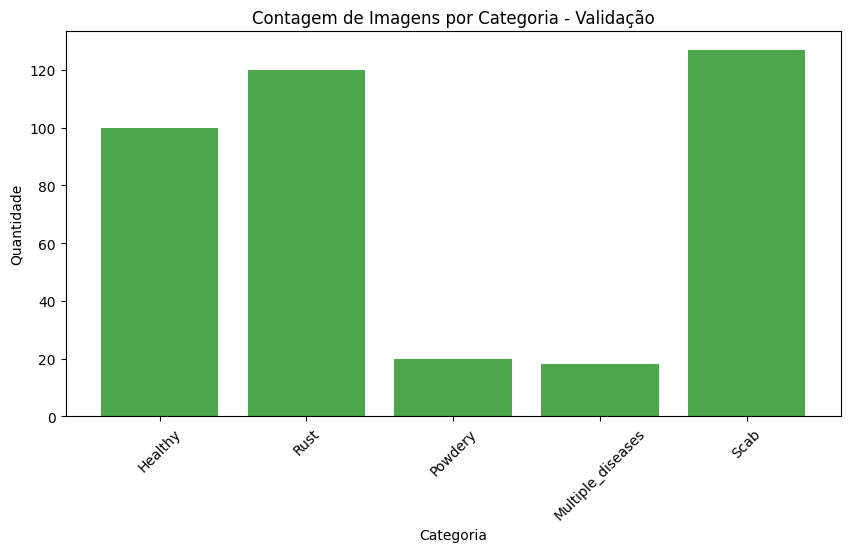

In [31]:
# Contar Imagens em Cada Categoria

# Criar um DataFrame para armazenar as contagens
df_treinamento = pd.DataFrame(list(contagem_treinamento.items()), columns=['Categoria', 'Quantidade'])
df_validacao = pd.DataFrame(list(contagem_validacao.items()), columns=['Categoria', 'Quantidade'])

# Plotar as contagens de imagens para o diretório de treinamento
plt.figure(figsize=(10, 5))
plt.bar(df_treinamento['Categoria'], df_treinamento['Quantidade'], color='blue', alpha=0.7)
plt.title('Contagem de Imagens por Categoria - Treinamento')
plt.xlabel('Categoria')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.show()

# Plotar as contagens de imagens para o diretório de validação
plt.figure(figsize=(10, 5))
plt.bar(df_validacao['Categoria'], df_validacao['Quantidade'], color='green', alpha=0.7)
plt.title('Contagem de Imagens por Categoria - Validação')
plt.xlabel('Categoria')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.show()

In [32]:
#salvando a variavel history em um arquivo csv para futuras analises
df = pd.DataFrame(history.history)
df.to_csv('history.csv', index=False)

In [ ]:

y_trueMinor = y_true[0:100]
y_predMinor = y_pred[0:100]


# Filtrar as imagens que foram classificadas incorretamente
incorrect_indices = [i for i, (true, pred) in enumerate(zip(y_trueMinor, y_predMinor)) if true != pred]

# Obter TODAS imagens do conjunto de validação e seus labels
val_images = []
val_labels = []

for images, labels in val_ds:
    val_images.extend(images.numpy())
    val_labels.extend(labels.numpy())




correct_indices =   [i for i, (true, pred) in enumerate(zip(y_trueMinor, y_predMinor)) if true == pred]
val_images = np.array(val_images)
val_labels = np.array(val_labels)



# Plotar as imagens incorretamente classificadas
print(len(incorrect_indices))
for i, idx in enumerate(incorrect_indices[:25]):
    plt.imshow(val_images[idx].astype("uint8"))
    plt.title(f"Pred: {y_pred_classes[y_predMinor[idx]]}\nTrue: {y_pred_classes[y_trueMinor[idx]]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



for i, idx in enumerate(correct_indices[:25]):
    plt.imshow(val_images[idx].astype("uint8"))
    plt.title(f"Pred: {y_pred_classes[y_predMinor[idx]]}\nTrue: {y_pred_classes[y_trueMinor[idx]]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
! pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.8.30
charset-normalizer           3.4.0
comm                         0.2.2
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.8
decorator                    5.1.1
exceptiongroup               1.2.2
executing                    2.1.0
flatbuffers                  24.3.25
fonttools                    4.55.0
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.68.0
h5py                         3.12.1
idna                         3.10
importlib_metadata           8.5.0
importlib_resources          6.4.5
ipykernel                    6.29.5
ipython                      8.18.1
jedi                         0.19.2
joblib                       1.4.2
jupyter_client               8.6.3
